<a href="https://colab.research.google.com/github/SalmanBhattti/Customer-Segmentation-using-K-Means-Clustering/blob/main/MSDS25032.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd




**We have impoted Library Pandas**

In [2]:
# Upload your file manually in Colab
from google.colab import files
uploaded = files.upload()

# Load the dataset (replace with your actual filename)
df = pd.read_csv("Mall_Customers.csv.csv")

# Show first 5 rows
df.head()

Saving Mall_Customers.csv.csv to Mall_Customers.csv (1).csv


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


**We have now loaded our data in colab.**

The dataset contains customer information collected by a mall’s marketing team.
It is commonly known as the Mall Customer Segmentation Dataset.

📘 **Dataset Description**

The data consists of 5 columns:

**CustomerID**

A unique numeric ID assigned to each customer.

Used only for identification (not used in clustering).

**Gender**

Categorical variable (Male/Female).

Helps analyze spending behavior across genders.

**Age**

Customer’s age in years.

Useful for identifying age-based customer segments.

**Annual Income (k**$)

Customer’s yearly income in thousands of dollars.

Important feature to identify purchasing power.

**Spending Score (1–100)**

A score assigned by the mall based on customer behavior and spending nature.

**Higher score = more spending and engagement.**

In [3]:
df.head()
df.info()
df.describe(include="all")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


In this step, I check the **basic structure** of the dataset.
I view the first few rows, data types, and summary statistics.
This helps me understand if there are missing values, incorrect data types, or unusual values .

In [4]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df.columns


Index(['customerid', 'gender', 'age', 'annual_income_(k$)',
       'spending_score_(1-100)'],
      dtype='object')

Column names sometimes contain spaces or inconsistent formatting.
I **clean** them by converting to lowercase and replacing spaces with underscores.
This makes the data **easier to work with**.


In [5]:
df.duplicated().sum()

# Remove duplicates
df = df.drop_duplicates()


Duplicate rows can cause errors in analysis.
Here, I check for **duplicate rows and remove them if any exist**.


In [6]:
df.isna().sum()


,0
customerid,0
gender,0
age,0
annual_income_(k$),0
spending_score_(1-100),0


Missing values can affect calculations and machine learning.
**I count the missing values in each column to decide how to handle them later.**


In [7]:
# Example: fill missing Age with median
df['age'] = df['age'].fillna(df['age'].median())

# Example: fill Gender missing with most frequent value
df['gender'] = df['gender'].fillna(df['gender'].mode()[0])


If a column has very few missing values, I can fill them with median (for numbers)
or mode (for categories). This keeps the dataset complete.


In [8]:
df['annual_income_(k$)'] = pd.to_numeric(df['annual_income_(k$)'], errors='coerce')
df['spending_score_(1-100)'] = pd.to_numeric(df['spending_score_(1-100)'], errors='coerce')


Sometimes numerical columns are stored as **text.**
I convert them to proper **numeric types** so mathematical operations work correctly.


In [9]:
df['gender'] = df['gender'].str.strip().str.lower()
df['gender'] = df['gender'].replace({'m':'male', 'f':'female'})
df['gender'].unique()


array(['male', 'female'], dtype=object)

Categorical values like Gender may have variations such as **'Male', 'male', 'M'.**
I standardize them to make the data consistent.


In [10]:
df['gender_code'] = df['gender'].map({'male':0, 'female':1})


Machine learning models need numbers, not words.
I convert Gender **into 0 and 1 **for easier processing later.


In [11]:
Q1 = df['annual_income_(k$)'].quantile(0.25)
Q3 = df['annual_income_(k$)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df[(df['annual_income_(k$)'] < lower_bound) | (df['annual_income_(k$)'] > upper_bound)]


,customerid,gender,age,annual_income_(k$),spending_score_(1-100),gender_code
198,199,male,32,137,18,0
199,200,male,30,137,83,0


Outliers are extremely high or low values.
I check for them using the IQR method.
This helps ensure the data is not distorted by extreme values.


In [12]:
df_clean = df[['age', 'annual_income_(k$)', 'spending_score_(1-100)', 'gender_code']]
df_clean.head()


,age,annual_income_(k$),spending_score_(1-100),gender_code
0,19,15,39,0
1,21,15,81,0
2,20,16,6,1
3,23,16,77,1
4,31,17,40,1


CustomerID is not useful for **clustering**, so I remove it.
I select the columns needed for analysis.


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean)

df_scaled[:5]   # show first 5 scaled rows


array([[-1.42456879, -1.73899919, -0.43480148, -1.12815215],
       [-1.28103541, -1.73899919,  1.19570407, -1.12815215],
       [-1.3528021 , -1.70082976, -1.71591298,  0.88640526],
       [-1.13750203, -1.70082976,  1.04041783,  0.88640526],
       [-0.56336851, -1.66266033, -0.39597992,  0.88640526]])

KMeans is affected by the scale of the data.
I standardize features so all columns have **similar scale**.


Columns in dataset: ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

Missing Values:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Summary Statistics:
       CustomerID        Age  Annual Income (k$)  Spending Score (1-100)
count    7.000000   7.000000            7.000000                7.000000
mean     4.000000  24.428571           16.285714               46.428571
std      2.160247   6.106203            1.112697               32.582496
min      1.000000  19.000000           15.000000                6.000000
25%      2.500000  20.500000           15.500000               22.500000
50%      4.000000  22.000000           16.000000               40.000000
75%      5.500000  27.000000           17.000000               76.500000
max      7.000000  35.000000           18.000000               81.000000

Data Types:
CustomerID                 int64
Gender

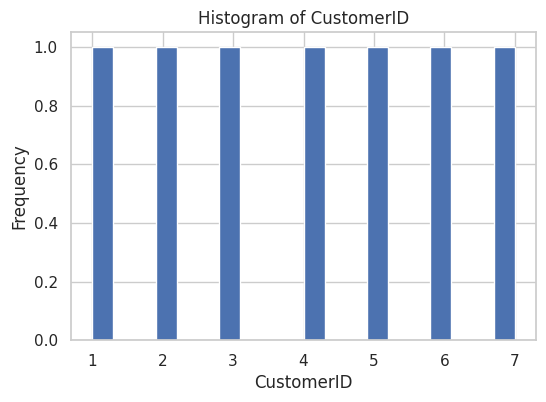

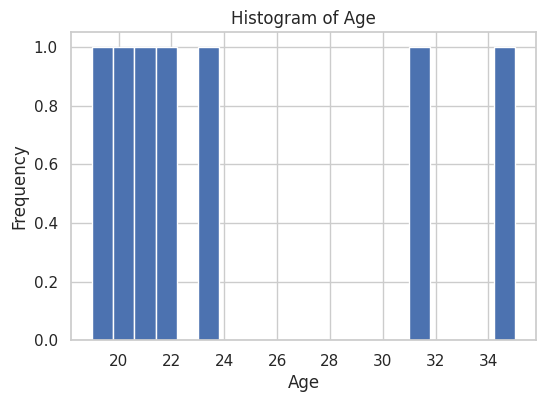

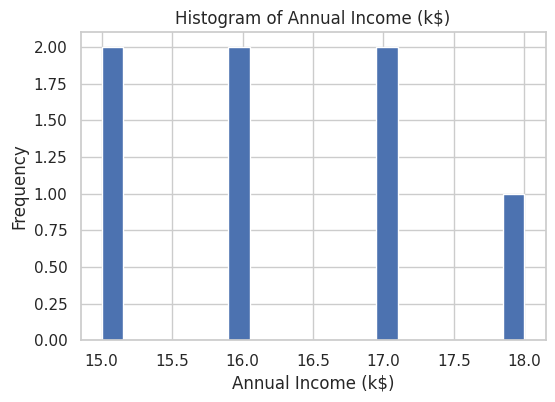

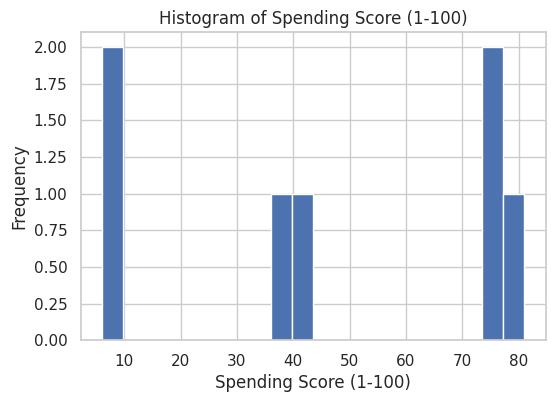

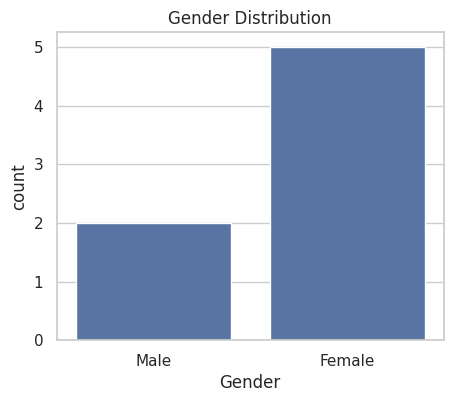

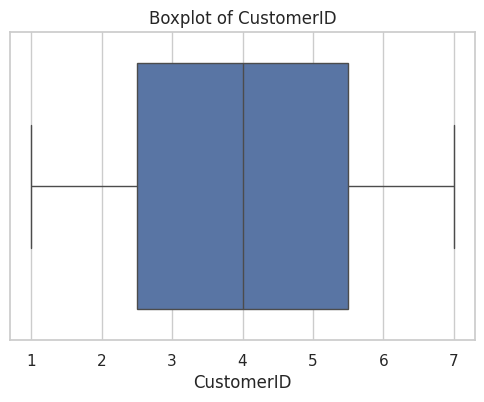

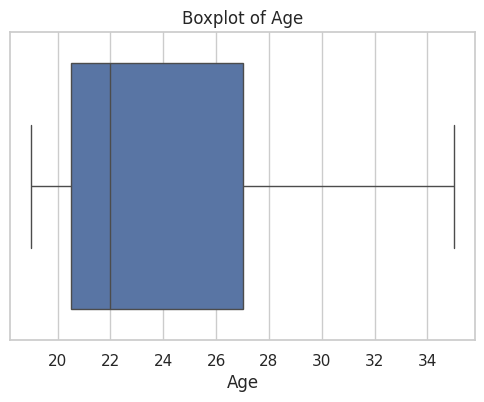

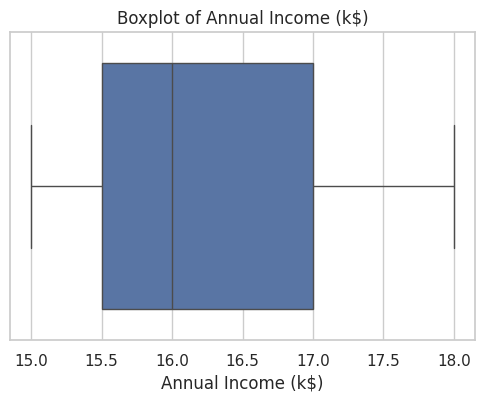

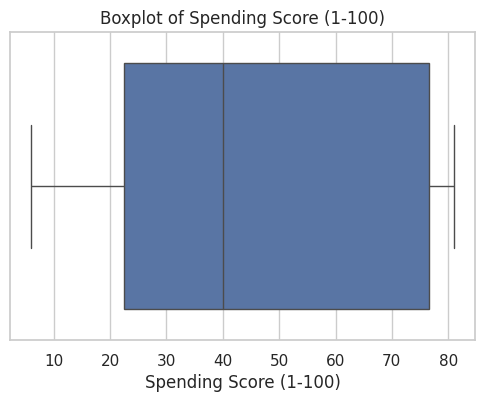

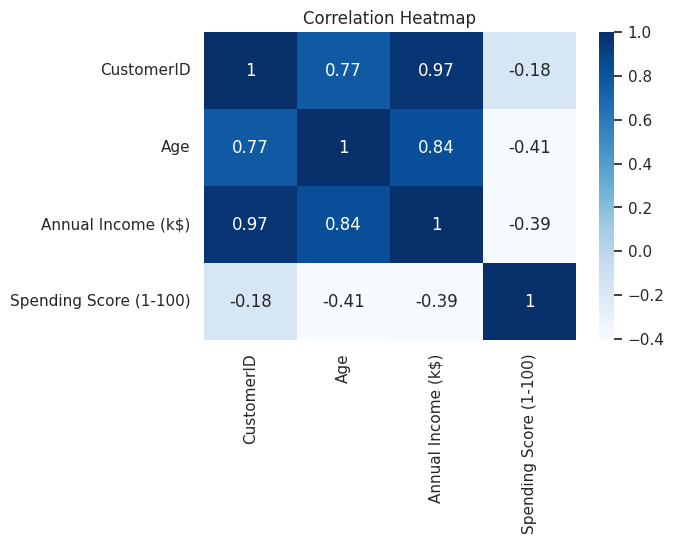

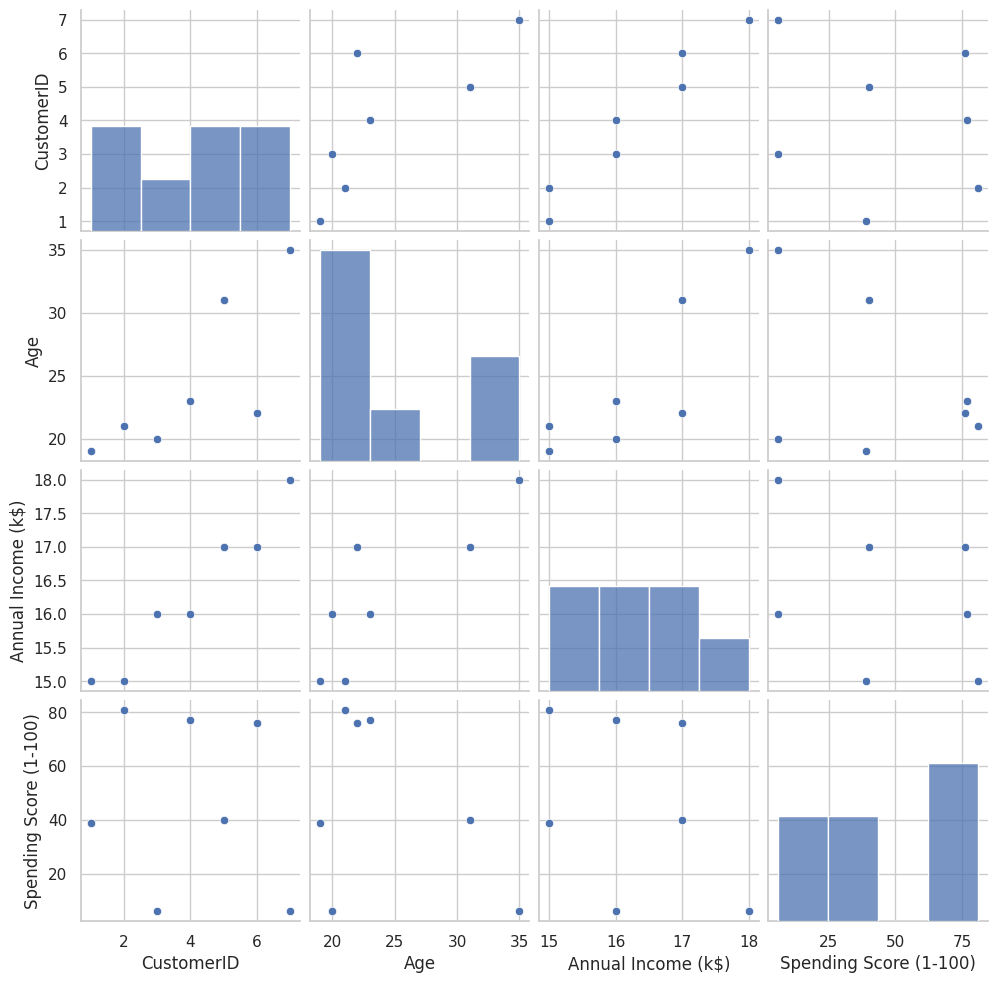

In [20]:
# ============================================================
# 1. IMPORT LIBRARIES
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")  # Clean plot style


# ============================================================
# 2. CHECK IF DATAFRAME EXISTS
# ============================================================
try:
    print("Columns in dataset:", df.columns.tolist())
except NameError:
    raise NameError("ERROR: Dataframe 'df' not found. Load your CSV before EDA.")


# ============================================================
# 3. CHECK MISSING VALUES
# ============================================================
try:
    print("\nMissing Values:")
    print(df.isnull().sum())
except Exception as e:
    print("Error checking missing values:", e)


# ============================================================
# 4. SUMMARY STATISTICS
# ============================================================
try:
    print("\nSummary Statistics:")
    print(df.describe())
except Exception as e:
    print("Error in summary statistics:", e)


# ============================================================
# 5. DATA TYPES
# ============================================================
try:
    print("\nData Types:")
    print(df.dtypes)
except Exception as e:
    print("Error showing data types:", e)


# ============================================================
# 6. HISTOGRAMS FOR NUMERIC COLUMNS
# ============================================================
try:
    numeric_cols = df.select_dtypes(include='number').columns

    for col in numeric_cols:
        plt.figure(figsize=(6,4))
        plt.hist(df[col], bins=20)
        plt.title(f"Histogram of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()
except Exception as e:
    print("Error in histogram section:", e)


# ============================================================
# 7. CATEGORY PLOT (Gender)
# ============================================================
if "Gender" in df.columns or "gender" in df.columns:
    try:
        gender_col = "Gender" if "Gender" in df.columns else "gender"

        plt.figure(figsize=(5,4))
        sns.countplot(x=df[gender_col])
        plt.title("Gender Distribution")
        plt.show()
    except Exception as e:
        print("Error in gender count plot:", e)
else:
    print("Gender column not found. Skipping gender plot.")


# ============================================================
# 8. BOXPLOTS (Outlier Detection)
# ============================================================
try:
    for col in numeric_cols:
        plt.figure(figsize=(6,4))
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot of {col}")
        plt.show()
except Exception as e:
    print("Error in boxplot section:", e)


# ============================================================
# 9. CORRELATION HEATMAP (NUMERIC ONLY)
# ============================================================
try:
    plt.figure(figsize=(6,4))
    numeric_df = df.select_dtypes(include='number')

    sns.heatmap(numeric_df.corr(), annot=True, cmap='Blues')
    plt.title("Correlation Heatmap")
    plt.show()
except Exception as e:
    print("Error in correlation heatmap:", e)


# ============================================================
# 10. PAIRPLOT (SCATTERPLOT MATRIX)
# ============================================================
try:
    if len(numeric_cols) >= 2:
        sns.pairplot(df[numeric_cols])
        plt.show()
    else:
        print("Not enough numeric columns for pairplot.")
except Exception as e:
    print("Error in pairplot section:", e)


**Step 1** — Import Libraries
We import pandas (data handling), numpy (numerical operations), matplotlib and seaborn (visualization).
seaborn style is set to "whitegrid" for cleaner plots.

**Step 2** — Check if DataFrame Exists

We confirm that the dataset df is loaded. If not, the code raises an error, preventing crashes later.

**Step 3** — Check Missing Values

We count missing values in each column to understand if the dataset has incomplete data that needs cleaning.

**Step 4** — Summary Statistics

We view basic descriptive statistics like mean, median, min, max, and standard deviation for numeric columns to understand data distribution.

**Step 5** — Data Types

We check data types of each column (int, float, object) to ensure numeric columns are suitable for analysis and categorical columns are correctly labeled.

**Step 6** — Histograms (Univariate Analysis)

We plot histograms of numeric columns (Age, Annual Income, Spending Score) to inspect distribution shape (skewed, normal, uniform, etc.).

**Step 7** — Category Plot (Gender)

We plot the count of Gender to see the distribution of male and female customers in the dataset.

**Step 8** — Boxplots (Outlier Detection)

Boxplots show the spread and detect outliers in numeric columns by visualizing median, quartiles, and extreme values.

**Step 9** — Correlation Heatmap

We compute correlations only for numeric columns and visualize them using a heatmap. This helps to see relationships between variables, e.g., Annual Income vs Spending Score.

**Step 10** — Pairplot (Scatterplot Matrix)

We create scatterplots for all numeric column pairs to visually inspect relationships, clusters, or trends between variables.

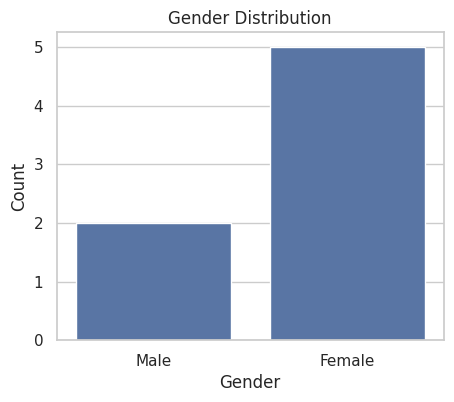

In [21]:
plt.figure(figsize=(5,4))
sns.countplot(x='Gender', data=df)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()


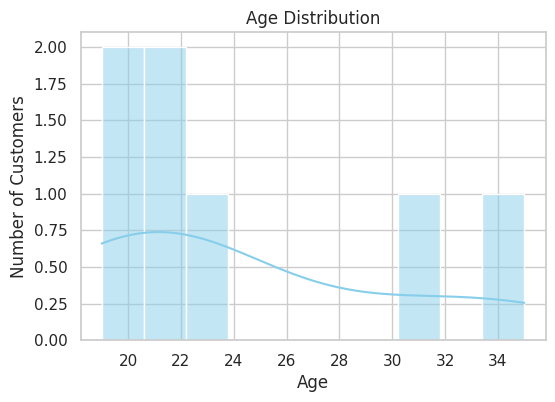

In [22]:
plt.figure(figsize=(6,4))
sns.histplot(df['Age'], bins=10, kde=True, color='skyblue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Number of Customers")
plt.show()


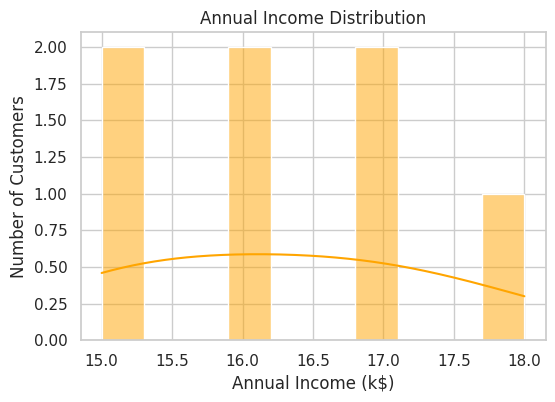

In [23]:
plt.figure(figsize=(6,4))
sns.histplot(df['Annual Income (k$)'], bins=10, kde=True, color='orange')
plt.title("Annual Income Distribution")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Number of Customers")
plt.show()


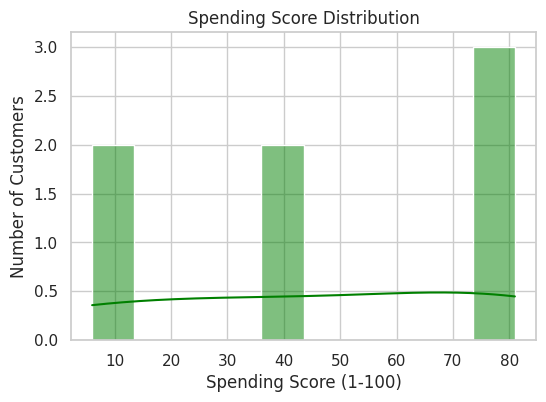

In [24]:
plt.figure(figsize=(6,4))
sns.histplot(df['Spending Score (1-100)'], bins=10, kde=True, color='green')
plt.title("Spending Score Distribution")
plt.xlabel("Spending Score (1-100)")
plt.ylabel("Number of Customers")
plt.show()


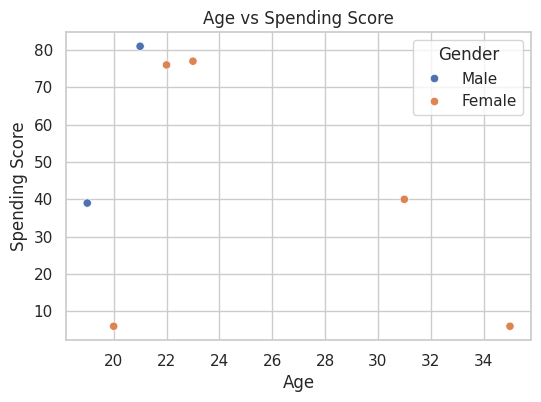

In [25]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='Age', y='Spending Score (1-100)', hue='Gender', data=df)
plt.title("Age vs Spending Score")
plt.xlabel("Age")
plt.ylabel("Spending Score")
plt.show()


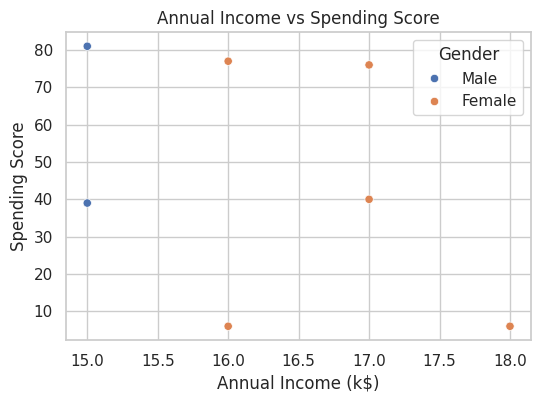

In [26]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Gender', data=df)
plt.title("Annual Income vs Spending Score")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score")
plt.show()


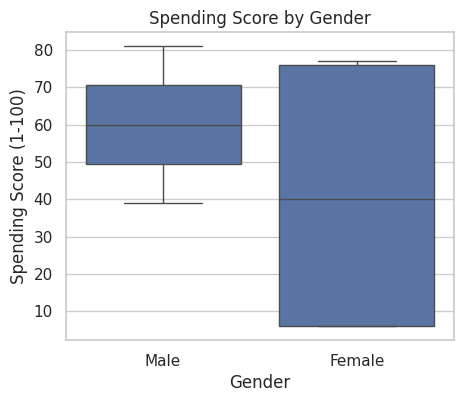

In [27]:
plt.figure(figsize=(5,4))
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=df)
plt.title("Spending Score by Gender")
plt.show()


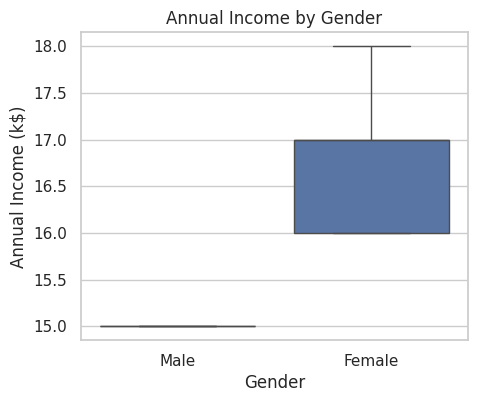

In [28]:
plt.figure(figsize=(5,4))
sns.boxplot(x='Gender', y='Annual Income (k$)', data=df)
plt.title("Annual Income by Gender")
plt.show()


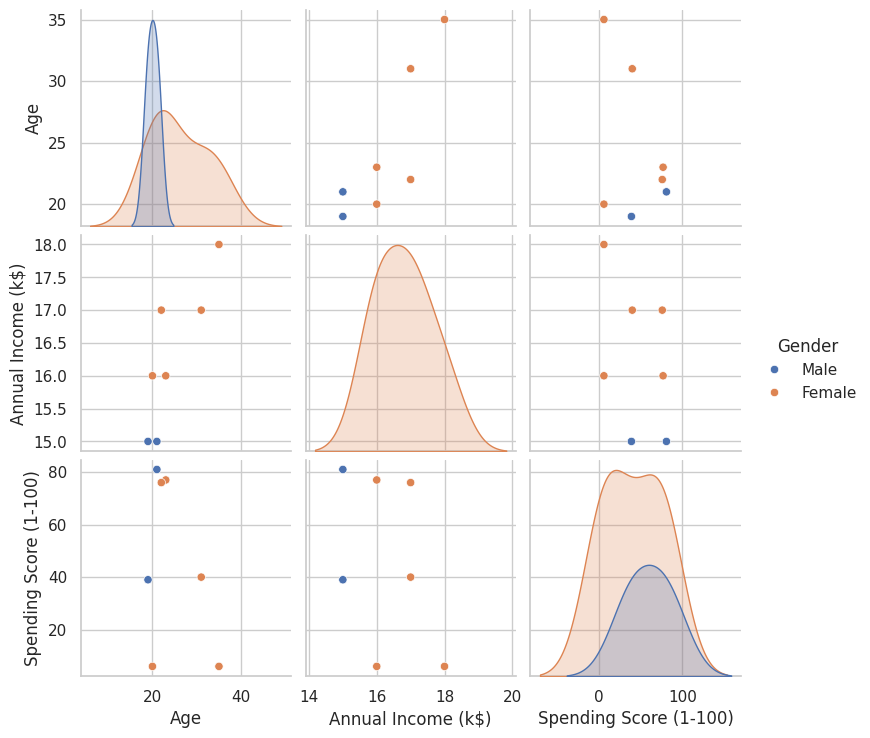

In [29]:
sns.pairplot(df[['Age','Annual Income (k$)','Spending Score (1-100)','Gender']], hue='Gender')
plt.show()


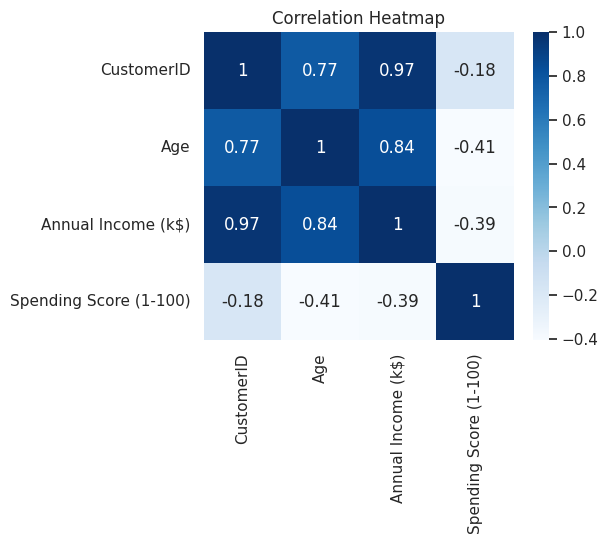

In [30]:
plt.figure(figsize=(5,4))
numeric_df = df.select_dtypes(include='number')
sns.heatmap(numeric_df.corr(), annot=True, cmap='Blues')
plt.title("Correlation Heatmap")
plt.show()


In [33]:
# Load the full dataset
df = pd.read_csv("/content/Mall_Customers.csv (1).csv")  # <-- your 200-row CSV

# Check number of rows
print("Number of rows:", df.shape[0])


Number of rows: 200


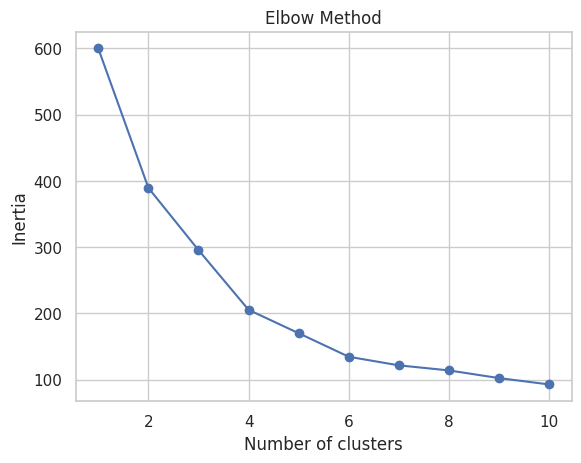

In [34]:
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method: max clusters = 10 (or less than number of samples)
from sklearn.cluster import KMeans
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


Dataset shape: (200, 5)
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


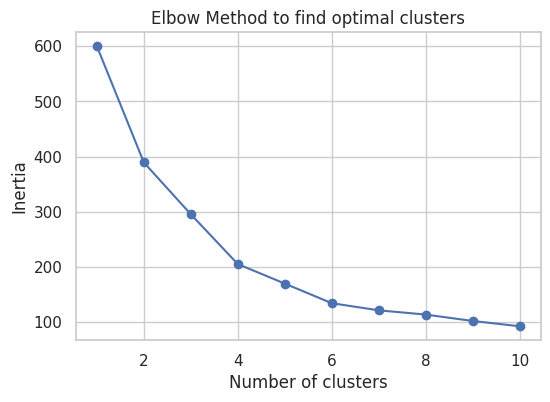

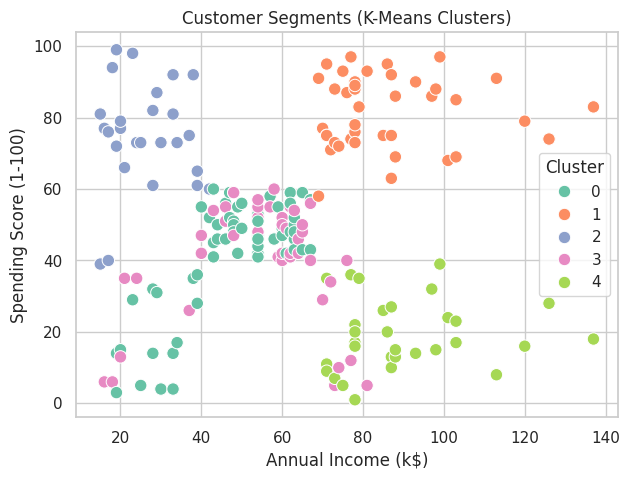


Cluster Summary (Mean values per cluster):
               Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                       
0        55.275862           47.620690               41.706897
1        32.875000           86.100000               81.525000
2        25.769231           26.115385               74.846154
3        26.733333           54.311111               40.911111
4        44.387097           89.774194               18.483871

Number of customers per cluster:
Cluster
0    58
1    40
2    26
3    45
4    31
Name: count, dtype: int64


In [36]:
# ============================================================
# 1️⃣ IMPORT LIBRARIES
# ============================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sns.set(style="whitegrid")

# ============================================================
# 2️⃣ LOAD DATA
# ============================================================
df = pd.read_csv("/content/Mall_Customers.csv (1).csv")

# Check dataset
print("Dataset shape:", df.shape)
print(df.head())

# ============================================================
# 3️⃣ SELECT FEATURES FOR CLUSTERING
# ============================================================
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# ============================================================
# 4️⃣ SCALE FEATURES
# ============================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ============================================================
# 5️⃣ ELBOW METHOD TO FIND OPTIMAL CLUSTERS
# ============================================================
inertia = []
max_clusters = 10  # Maximum clusters to try
for k in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(6,4))
plt.plot(range(1, max_clusters+1), inertia, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method to find optimal clusters")
plt.show()

# ============================================================
# 6️⃣ FIT K-MEANS WITH OPTIMAL CLUSTERS
# ============================================================
optimal_k = 5  # Set based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# ============================================================
# 7️⃣ VISUALIZE CLUSTERS (Annual Income vs Spending Score)
# ============================================================
plt.figure(figsize=(7,5))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Cluster', palette='Set2', data=df, s=80)
plt.title("Customer Segments (K-Means Clusters)")
plt.show()

# ============================================================
# 8️⃣ CLUSTER SUMMARY
# ============================================================
cluster_summary = df.groupby('Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()
print("\nCluster Summary (Mean values per cluster):")
print(cluster_summary)

# Optional: count of customers in each cluster
cluster_counts = df['Cluster'].value_counts().sort_index()
print("\nNumber of customers per cluster:")
print(cluster_counts)


**Explanation**

Import libraries – pandas, seaborn/matplotlib for visualization, sklearn for ML.

Load your CSV – now using /content/Mall_Customers.csv (1).csv.

Select features – numeric columns for clustering.

Scale features – ensures equal weight for Age, Income, Spending Score.

Elbow method – plot inertia to choose optimal clusters (k).

Fit K-Means – assign cluster numbers to customers.

Visualize clusters – scatter plot of Income vs Spending Score.

Cluster summary – mean Age, Income, Spending Score per cluster and counts.